In [ ]:
!pip install numpy==1.21.4
!pip install opencv-python
!pip install dlib
!pip install matplotlib
!pip install Pillow --upgrade
!pip install librosa
!pip install numba==0.53
!pip install opensmile
!pip install PyYAML==5.4.1
!pip install sox
!pip install sklearn


In [1]:
!pip install opencv-contrib-python

/home/shemetov@ad.speechpro.com/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/shemetov@ad.speechpro.com/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
import logging
import threading
import pandas as pd
import torch.nn.functional as F
import torchaudio.transforms as T
import time
from IPython.display import display, Image
import ipywidgets as widgets
import threading
import concurrent.futures
from PIL import Image
import os
import glob
import re
from sklearn.preprocessing import StandardScaler
import librosa
import sklearn
import torch
import torchaudio
import torch.utils.data
import torch.nn as nn
import librosa.display
import librosa.filters
import IPython.display as ipd
from sklearn.metrics import classification_report, confusion_matrix
import opensmile
from sklearn.model_selection import train_test_split
from platform import python_version
torch.manual_seed(20)

In [2]:
set_of_classes = ['SAD','NEU','HAP','FEA','DIS','ANG']

            

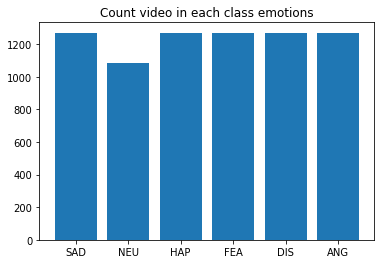

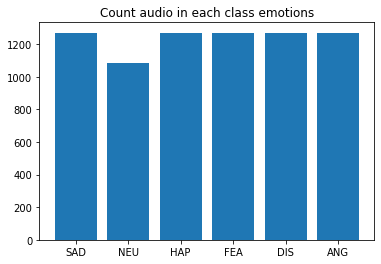

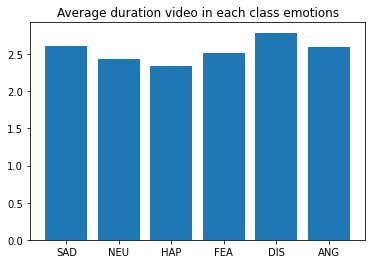

In [253]:

#static_analyze
dct_classes = {'SAD':0,'NEU':0,'HAP':0,'FEA':0,'DIS':0,'ANG':0}
fig1, ax1 = plt.subplots()

for file_path in set_of_classes:
    list_of_files = sorted(glob.glob('./CREMA-D/VideoFlash/*' + file_path + '*.flv'))
    dct_classes[file_path] = len(list_of_files)
ax1.bar(dct_classes.keys(), dct_classes.values())
ax1.set_title("Count video in each class emotions")

fig2, ax2 = plt.subplots()

for file_path in set_of_classes:
    list_of_files = sorted(glob.glob('./CREMA-D/AudioClass/' + file_path + '/*.wav'))
    dct_classes[file_path] = len(list_of_files)
ax2.bar(dct_classes.keys(), dct_classes.values())
ax2.set_title("Count audio in each class emotions")


fig3, ax3 = plt.subplots()
dct_avg_len_of_videos = {'SAD':0,'NEU':0,'HAP':0,'FEA':0,'DIS':0,'ANG':0}
for file_path in set_of_classes:
    list_of_files = sorted(glob.glob('./CREMA-D/VideoFlash/*' + file_path + '*.flv'))
    sum_var = 0
    for video_path in list_of_files:
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = frame_count/fps
        seconds = duration%60
        sum_var += seconds
    dct_avg_len_of_videos[file_path] = round(sum_var / len(list_of_files),3)

ax3.bar(dct_avg_len_of_videos.keys(), dct_avg_len_of_videos.values())
ax3.set_title("Average duration video in each class emotions")



cap.release()


In [ ]:
#Cut video on images and save in folders
for file_path in set_of_classes:
    list_of_files = sorted(glob.glob('./CREMA-D/VideoFlash/*' + file_path + '*.flv'))
    count = 0
    for video_path in list_of_files:
        order_var = re.findall(r'\d{1,5}',video_path)[0]
        cap = cv2.VideoCapture(video_path)
        success,image = cap.read()
        while success:
            #print("CREMA-D/ImageClass/" + file_path + "/" + order_var + "_frame%d.jpg" % count)
            cv2.imwrite("CREMA-D/ImageClass/" + file_path + "/" + order_var + "_frame%d.jpg" % count, image)
            success,image = cap.read()
            count += 1

In [ ]:
#Face Recognation with HAAD Cascade
for file_path in set_of_classes:
    list_of_files = sorted(glob.glob('./CREMA-D/ImageClass/' + file_path + '/*.jpg'))
    count = 0
    for image_path in list_of_files:
        order_var = re.findall(r'\d{1,5}',image_path)[0]
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
        face = faceCascade.detectMultiScale(
                gray,
                scaleFactor=1.2,
                minNeighbors=6,
                minSize=(30, 30)
        )

        if len(face) != 0:
            x, y, w, h = face[0]
        gray_color = gray[y:y + h, x:x + w]
        res = cv2.resize(gray_color,(128,128))
        #gray = cv2.cvtColor(roi_color, cv2.COLOR_BGR2GRAY)
        cv2.imwrite("CREMA-D/FaceClass/" + file_path + "/" + order_var + "_frame%d.jpg" % count, res)
        count += 1
        #display(Image.fromarray(res))
        

SIFT признаки

In [6]:
#Create Dataset with SIFT features for pytorch 
class ImageDatasetSIFT(torch.utils.data.Dataset):
    def __init__(self,dir_paths = None, labels=None, le = None):
        super(ImageDatasetSIFT, self).__init__()
        self.dir_paths = dir_paths
        self.labels = labels
        self.image_files = []
        self.set_of_labels = []
        if self.labels is not None:
            for label in self.labels:
                images_path = glob.glob(self.dir_paths + label + '/*.jpg')[0:10000]
                for image_path in tqdm(images_path):
                    gray_image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                    sift = cv2.SIFT_create(20)
                    _,des = sift.detectAndCompute(gray_image,None)
                    
                    if (des is None) or len(des) !=20:
                        continue
                    else:
                        self.image_files.append(des)
                len_image_files = len(self.image_files)
                label = list(le.transform([label]))
                self.set_of_labels += label * len_image_files
                #self.image_files += images_path
                
            
    def __getitem__(self, index):
        label = self.set_of_labels[index]
        des = self.image_files[index]
        feature = F.normalize(torch.FloatTensor(np.array([des[0:20]])),p=2.0)
        return feature, label

    def __len__(self):
        return len(self.image_files)

In [7]:
#Create traind and test.
extractor = None
le = sklearn.preprocessing.LabelEncoder()
le = le.fit(set_of_classes)
dir_path = '/home/shemetov@ad.speechpro.com/Desktop/testpy/CREMA-D/FaceClass/'

data_sift = ImageDatasetSIFT(dir_paths=dir_path,labels=set_of_classes,le=le)
print(len(data_sift))
print(int(len(data_sift) * 0.8) + int(len(data_sift) * 0.2))
print(np.shape(next(iter(data_sift))[0]))

100%|██████████| 10000/10000 [00:24<00:00, 409.99it/s]

49612
49611
torch.Size([1, 20, 128])


In [8]:
train_sift, test_sift = torch.utils.data.random_split(data_sift,[int(len(data_sift) * 0.8),int(len(data_sift) * 0.2)+1])
train_set_sift = torch.utils.data.DataLoader(train_sift, batch_size=32, shuffle=True)
test_set_sift = torch.utils.data.DataLoader(test_sift, batch_size=32, shuffle=False)

In [46]:
class CNNSIFT(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 128, kernel_size = 5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(2, 2)
        self.dp1 = nn.Dropout2d()
        self.conv2 = nn.Conv2d(out_channels, out_channels * 2, 5)
        #self.pool = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(out_channels * 2)
        self.dp2 = nn.Dropout2d()
        self.fc1 = nn.Linear(14848, 64)
        self.fc2 = nn.Linear(64, 40)
        self.fc3 = nn.Linear(40, 6)
        
    def forward(self, x):
        x = self.pool(F.relu((self.conv1(x))))
        #x = self.dp1(x)
        x = self.pool(F.relu((self.conv2(x))))
        #x = self.dp2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNSIFT().to(device)

In [45]:
#Structure of Model
class CNN(nn.Module):
    def __init__(self, in_channels = 1,out_channels = 128,kernel_size = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.pool1 = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.drop2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(out_channels, 2 * out_channels, 3)
        self.bn3 = nn.BatchNorm2d(2 * out_channels)
        self.drop3 = nn.Dropout(0.2)
        self.pool3 = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(11520, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 6)


    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))
        return F.log_softmax(x,dim=1)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [47]:
import torch.optim as optim

#Optimization for model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from tqdm import tqdm

video_features_lbp = []
video_pred_lbp = []
#Train model
for epoch in range(25):
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_set_sift, 0)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        if i % 1000 == 999: 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
    y_pred = None
    y_test = None
    model.eval()
    with torch.no_grad():
        for inputs,target in tqdm(test_set_sift):
            inputs = inputs.to(device)
            output = model(inputs)
            video_features_lbp.append(output.cpu())
            video_pred_lbp.append(target)
            y_preds = output.argmax(dim=-1).to('cpu').detach().numpy()
            if y_pred is not None:
                y_pred = np.concatenate([y_pred, y_preds])
                target  = np.concatenate([y_test, target])
            else:
                y_pred = y_preds
                y_test = target
    f1 = sklearn.metrics.f1_score(y_test, y_preds, average='macro')
    acc = sklearn.metrics.accuracy_score(y_test, y_preds)
    precision = sklearn.metrics.precision_score(y_test, y_preds, average='macro')
    recall = sklearn.metrics.recall_score(y_test, y_preds, average='macro')
    print('metrics:', acc, f1, precision, recall)

print('Finished Training')

In [72]:
f1 = sklearn.metrics.f1_score(y_test, y_pred, average='macro')
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
print('metrics:', 'acc:', round(acc,2),'f1:', round(f1,2))


metrics: acc: 0.56 f1: 0.55


LBP признак

In [12]:
#Create Dataset for pytorch
class ImageDataset(torch.utils.data.Dataset):
    """Some Information about MyDataset"""
    def __init__(self,dir_paths = None, labels=None, le = None,  extractor = None):
        super(ImageDataset, self).__init__()
        self.dir_paths = dir_paths
        self.labels = labels
        self.extractor = extractor
        self.image_features = []
        self.set_of_labels = []
        for i in self.dir_paths:
            output = pd.read_pickle(i)
            self.image_features += output['Features'].values[0][0:int(len(output['Features'].values[0])*0.1)]
            self.set_of_labels += list(le.transform(output['Labels'].values[0][0:int(len(output['Labels'].values[0])*0.1)]))

                
            
    def __getitem__(self, index):
        label = self.set_of_labels[index]
        features = torch.FloatTensor(np.array([self.image_features[index]]))/255
        return features, label

    def __len__(self):
        return len(self.image_features)

In [ ]:
#extract LBP features.Not fast version
from tqdm import tqdm
from itertools import repeat
import concurrent.futures

def LBP(img):
    arr = np.zeros((len(img),len(img[0])))
    img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_REFLECT)
    img = np.array(img)
    for i in range(len(img)-2):
        for j in range(len(img[i])-2):
            arr[i][j] = (img[i + 1][j + 1] < img[i][j]) * 1 + \
                        (img[i + 1][j + 1] < img[i][j+1]) * 2 + \
                        (img[i + 1][j + 1] < img[i][j+2]) * 4 + \
                        (img[i + 1][j + 1] < img[i+1][j+2]) * 8 + \
                        (img[i + 1][j + 1] < img[i+2][j+2]) * 16 + \
                        (img[i + 1][j + 1] < img[i+2][j+1]) * 32 + \
                        (img[i + 1][j + 1] < img[i+2][j]) * 64 + \
                        (img[i + 1][j + 1] < img[i+1][j]) * 128
    return np.uint8(arr)

def get_features(file_path):
    X_data = []
    y_data = []
    
    for file_path in set_of_classes:
        list_of_files = sorted(glob.glob('./CREMA-D/FaceClass/' + file_path + '/*.jpg'))
        count = 0
        for image_path in list_of_files:
            gray = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
            arr_img = LBP(gray)
            display(Image.fromarray(arr_img))
            X_data.append(arr_img)
            y_data.append(file_path)

    return X_data, y_data



        
with concurrent.futures.ThreadPoolExecutor(max_workers=6) as ex:
    SAD_res = ex.submit(get_features, set_of_classes[0])
    NEU_res = ex.submit(get_features, set_of_classes[1])
    HAP_res = ex.submit(get_features, set_of_classes[2])
    FEA_res = ex.submit(get_features, set_of_classes[3])
    DIS_res = ex.submit(get_features, set_of_classes[4])
    ANG_res = ex.submit(get_features, set_of_classes[5])




In [7]:
#extract LBP features. Fast version with threads

import cv2
import numpy as np
from matplotlib import pyplot as plt

def get_pixel(img, center, x, y):
	new_value = 0
	try:
		if img[x][y] >= center:
			new_value = 1
	except:
		pass

	return new_value

# Function for calculating LBP
def lbp_calculated_pixel(img, x, y):
	center = img[x][y]
	val_ar = []

	val_ar.append(get_pixel(img, center, x-1, y-1))
	
	val_ar.append(get_pixel(img, center, x-1, y))
	
	val_ar.append(get_pixel(img, center, x-1, y + 1))

	val_ar.append(get_pixel(img, center, x, y + 1))
	
	val_ar.append(get_pixel(img, center, x + 1, y + 1))
	
	val_ar.append(get_pixel(img, center, x + 1, y))
	
	val_ar.append(get_pixel(img, center, x + 1, y-1))
	
	val_ar.append(get_pixel(img, center, x, y-1))
	
	power_val = [1, 2, 4, 8, 16, 32, 64, 128]

	val = 0
	
	for i in range(len(val_ar)):
		val += val_ar[i] * power_val[i]
		
	return val


def LBP(img):
    height, width = 128,128
    img_lbp = np.zeros((height, width),
				np.uint8)
    for i in range(0, height):
        for j in range(0, width):
            img_lbp[i, j] = lbp_calculated_pixel(img, i, j)
    return img_lbp

def get_features(file_path):
    #s = start_time()
    X_data = []
    y_data = []
    count = 0
    print(file_path)
    list_of_files = sorted(glob.glob('./CREMA-D/FaceClass/' + file_path + '/*.jpg'))

    for image_path in list_of_files:
        if count % 1000 == 999:
            print(file_path," - ", count)
        gray = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
        arr_img = LBP(gray)
        X_data.append(arr_img)
        y_data.append(file_path)
        count += 1

    return X_data, y_data


with concurrent.futures.ProcessPoolExecutor(max_workers=6) as ex:
    SAD_res = ex.submit(get_features, set_of_classes[0])
    NEU_res = ex.submit(get_features, set_of_classes[1])
    HAP_res = ex.submit(get_features, set_of_classes[2])
    FEA_res = ex.submit(get_features, set_of_classes[3])
    DIS_res = ex.submit(get_features, set_of_classes[4])
    ANG_res = ex.submit(get_features, set_of_classes[5])

print("LBP Program is finished")


SADHAPNEUFEADISANG







KeyboardInterrupt: 

In [4]:
#reference to dirs where we want to save our dataframes
filepath = '/home/shemetov@ad.speechpro.com/Desktop/testpy/lbp_features_SAD'
filepath1 = '/home/shemetov@ad.speechpro.com/Desktop/testpy/lbp_features_NEU'
filepath2 = '/home/shemetov@ad.speechpro.com/Desktop/testpy/lbp_features_DIS'
filepath3 = '/home/shemetov@ad.speechpro.com/Desktop/testpy/lbp_features_FEA'
filepath4 = '/home/shemetov@ad.speechpro.com/Desktop/testpy/lbp_features_ANG'
filepath5 = '/home/shemetov@ad.speechpro.com/Desktop/testpy/lbp_features_HAP'
filepaths = [filepath,filepath1,filepath2,filepath3,filepath4,filepath5]

In [6]:
#create DataFrames for each emotion
df_SAD = pd.DataFrame(columns = ['Features', 'Labels'])
df_NEU = pd.DataFrame(columns = ['Features', 'Labels'])
df_DIS = pd.DataFrame(columns = ['Features', 'Labels'])
df_FEA = pd.DataFrame(columns = ['Features', 'Labels'])
df_ANG = pd.DataFrame(columns = ['Features', 'Labels'])
df_HAP = pd.DataFrame(columns = ['Features', 'Labels'])

#df.to_pickle(filepath)
df_SAD.to_pickle(filepath)
df_NEU.to_pickle(filepath1)
df_DIS.to_pickle(filepath2)
df_FEA.to_pickle(filepath3)
df_ANG.to_pickle(filepath4)
df_HAP.to_pickle(filepath5)

In [7]:
#Add result of LBP extraction to DataFrames
df_SAD = df_SAD.append({'Features':SAD_res.result()[0],'Labels':SAD_res.result()[1]},ignore_index=True)
df_NEU = df_NEU.append({'Features':NEU_res.result()[0],'Labels':NEU_res.result()[1]},ignore_index=True)
df_DIS = df_DIS.append({'Features':HAP_res.result()[0],'Labels':HAP_res.result()[1]},ignore_index=True)
df_FEA = df_FEA.append({'Features':FEA_res.result()[0],'Labels':FEA_res.result()[1]},ignore_index=True)
df_ANG = df_ANG.append({'Features':DIS_res.result()[0],'Labels':DIS_res.result()[1]},ignore_index=True)
df_HAP = df_HAP.append({'Features':ANG_res.result()[0],'Labels':ANG_res.result()[1]},ignore_index=True)
#df.to_pickle(filepath)

Формируем датасет из признаков LBP для обучения

In [13]:
filepath = '/home/shemetov@ad.speechpro.com/Desktop/testpy/lbp_features_SAD'
filepath1 = '/home/shemetov@ad.speechpro.com/Desktop/testpy/lbp_features_NEU'
filepath2 = '/home/shemetov@ad.speechpro.com/Desktop/testpy/lbp_features_DIS'
filepath3 = '/home/shemetov@ad.speechpro.com/Desktop/testpy/lbp_features_FEA'
filepath4 = '/home/shemetov@ad.speechpro.com/Desktop/testpy/lbp_features_ANG'
filepath5 = '/home/shemetov@ad.speechpro.com/Desktop/testpy/lbp_features_HAP'
filepaths = [filepath,filepath1,filepath2,filepath3,filepath4,filepath5]

In [14]:
extractor = None
le = sklearn.preprocessing.LabelEncoder()
le = le.fit(set_of_classes)

data = ImageDataset(dir_paths=filepaths,labels=set_of_classes,le=le,extractor=extractor)
print(len(data))
print(int(len(data) * 0.8) + int(len(data) * 0.2))
print(np.shape(next(iter(data))[0]))
train, test = torch.utils.data.random_split(data,[int(len(data) * 0.8)+1,int(len(data) * 0.2)])
train_set = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
test_set = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

57052
57051
torch.Size([1, 128, 128])


In [15]:
class CNN(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 128, kernel_size = 5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(out_channels, out_channels * 2, 5)
        self.fc1 = nn.Linear(215296, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

##Первая модель(неиспоьузется)

In [58]:
class CNNet(nn.Module):
    def __init__(self, in_channels = 1,out_channels = 128,kernel_size = 5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.pool1 = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.drop2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(out_channels, 2 * out_channels, 3)
        self.bn3 = nn.BatchNorm2d(2 * out_channels)
        self.drop3 = nn.Dropout(0.2)
        self.pool3 = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(2 * out_channels, 2 * out_channels, 3)
        self.bn4 = nn.BatchNorm2d(2 * out_channels)
        self.drop4 = nn.Dropout(0.2)
        self.pool4 = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(50176, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 6)


    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.pool3(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(x,dim=1)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNet().to(device)

In [57]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(2048, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ResNet(1,6).to(device)

cuda


In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008, weight_decay= 0.0001)

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#Training model

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(train_set, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
    #print('loss:', sum(running_loss)/len(running_loss))

print('Finished Training')

In [23]:
#save model for future
torch.save(model, '/home/shemetov@ad.speechpro.com/Desktop/testpy/model')

In [16]:
model = torch.load('/home/shemetov@ad.speechpro.com/Desktop/testpy/model')

In [17]:
#Validation

y_preds = None
targets = None
video_features_lbp = []
video_pred_lbp = []
model.eval()
with torch.no_grad():
  for inputs,target in tqdm(test_set):
    video_pred_lbp.append(target)    
    inputs = inputs.to(device)
    output = model(inputs)
    video_features_lbp.append(output.cpu())
   #print(np.shape(output))
    y_pred = output.argmax(dim=-1).to('cpu').detach().numpy()
    #print(y_pred,target)
    if y_preds is not None:
            y_preds = np.concatenate([y_preds, y_pred])
            targets  = np.concatenate([targets, target])
    else:
            y_preds = y_pred
            targets = target
f1 = sklearn.metrics.f1_score(targets, y_preds, average='macro')
acc = sklearn.metrics.accuracy_score(targets, y_preds)
precision = sklearn.metrics.precision_score(targets, y_preds, average='macro')
recall = sklearn.metrics.recall_score(targets, y_preds, average='macro')
print('metrics:', 'acc:', acc, f1, precision, recall)


100%|██████████| 357/357 [00:06<00:00, 52.39it/s]


metrics: acc: 0.9757230499561788 0.9753961959838612 0.9756138376804229 0.9753374731341701


------------------------------- Аудио сектор ----------------------------------

In [50]:
def mel(spec):
    spec = 1125 * np.log(1 + spec/700)
    return spec

In [51]:
#Create Dataset with MFCC features for pytorch

class WavDataset(torch.utils.data.Dataset):
    """Some Information about MyDataset"""
    def __init__(self,dir_path = None, labels=None, le = None,  extractor = None):
        super(WavDataset, self).__init__()
        self.dir_path = dir_path
        self.labels = labels
        self.extractor = extractor
        self.pad_size = 0
        self.wav_files = []
        self.set_of_labels = []
        count = 0
        if self.labels is not None:
            for label in self.labels:
                wav_paths = glob.glob(dir_path + label + '/*.wav')
                len_wav_files = len(wav_paths)
                label = list(le.transform([label]))
                self.set_of_labels += label * len_wav_files
                self.wav_files += wav_paths
                for i in wav_paths:
                    wav = torchaudio.load(i)[0][0]
                    self.pad_size += len(wav)
                    count += 1
            self.pad_size = self.pad_size // count

                
            
    def __getitem__(self, index):
        start_time = time.time()
        wav, sr =  torchaudio.load(self.wav_files[index])
        label = self.set_of_labels[index]
        if self.pad_size:
            p = (self.pad_size - len(wav.flatten())) // 2 + 1
            if p>0:
                wav = torch.nn.functional.pad(wav, (p, p), value=0.0)
            wav = wav[:, :self.pad_size]
        if self.extractor is not None:
            features = extractor(wav)
        #print("debug __get_item__","--- %s seconds ---" % (time.time() - start_time))
        return features, label

    def __len__(self):
        return len(self.wav_files)

In [52]:
#Setting for MFCC

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)




In [53]:
#Traind and val sets

extractor = mfcc_transform
le = sklearn.preprocessing.LabelEncoder()
le = le.fit(set_of_classes)
dir_path = '/home/shemetov@ad.speechpro.com/Desktop/testpy/CREMA-D/AudioClass/'

data_wav = WavDataset(dir_path=dir_path,labels=set_of_classes,le=le,extractor=extractor)
print(len(data_wav))
print(int(len(data_wav) * 0.8) + int(len(data_wav) * 0.2))

print(next(iter(data_wav))[1])
train_wav, test_wav = torch.utils.data.random_split(data_wav,[int(len(data_wav) * 0.8)+1,int(len(data_wav) * 0.2)])
train_set_wav = torch.utils.data.DataLoader(train_wav, batch_size=32, shuffle=True)
test_set_wav = torch.utils.data.DataLoader(test_wav, batch_size=32, shuffle=False)

7442
7441
5


In [60]:
class CNNet(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 128, kernel_size = 5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(out_channels, out_channels * 2, 5)
        self.fc1 = nn.Linear(265472, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 6)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNet().to(device)

In [55]:
class CNNet(nn.Module):
    def __init__(self, in_channels = 1,out_channels = 32,kernel_size = 5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.pool1 = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool2 = nn.MaxPool2d(2,2)
        self.drop2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(out_channels, 2 * out_channels, 3)
        self.bn3 = nn.BatchNorm2d(2 * out_channels)
        self.drop3 = nn.Dropout(0.2)
        self.pool3 = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(2 * out_channels, 2 * out_channels, 3)
        self.bn4 = nn.BatchNorm2d(2 * out_channels)
        self.drop4 = nn.Dropout(0.2)
        self.pool4 = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2688, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 6)


    def forward(self, x):
        x = F.relu(self.pool1(self.bn1(self.conv1(x))))
        x = self.drop1(x)
        x = F.relu(self.pool2(self.bn2(self.conv2(x))))
        x = self.drop2(x)
        x = F.relu(self.pool3(self.bn3(self.conv3(x))))
        x = self.drop3(x)
        x = F.relu(self.pool4(self.bn4(self.conv4(x))))
        x = self.drop4(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(x,dim=1)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNet().to(device)

In [61]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from tqdm import tqdm

for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(train_set_wav, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    #print('loss:', sum(running_loss)/len(running_loss))

print('Finished Training')

In [48]:
torch.save(model, '/home/shemetov@ad.speechpro.com/Desktop/testpy/modelCNN')

In [57]:
model = torch.load('/home/shemetov@ad.speechpro.com/Desktop/testpy/modelCNN')

In [63]:
y_pred = []
y_test = []
audio_features_mfcc = []
audio_pred_mfcc = []
model.eval()
with torch.no_grad():
  for inputs,target in tqdm(test_set_wav):
    inputs = inputs.to(device)
    audio_pred_mfcc.append(target)
    y_test.extend(target.numpy())
    output = model(inputs)
    audio_features_mfcc.append(output.cpu())
    #print(np.shape(output))
    for idx, i in enumerate(output):
      y_pred.append(torch.argmax(i).item())
  

100%|██████████| 47/47 [00:02<00:00, 17.71it/s]


In [64]:
print(classification_report(y_test, y_pred))
f1 = sklearn.metrics.f1_score(y_test, y_pred, average='macro')
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred, average='macro')
recall = sklearn.metrics.recall_score(y_test, y_pred, average='macro')
print('metrics:', 'acc:',acc,'f1:',f1,'prec:',precision,'recall:',recall)

              precision    recall  f1-score   support

           0       0.60      0.77      0.67       235
           1       0.45      0.56      0.50       245
           2       0.54      0.42      0.47       241
           3       0.59      0.57      0.58       256
           4       0.60      0.53      0.56       250
           5       0.58      0.51      0.54       261

    accuracy                           0.56      1488
   macro avg       0.56      0.56      0.55      1488
weighted avg       0.56      0.56      0.55      1488

metrics: acc: 0.5571236559139785 f1: 0.5545697742847703 prec: 0.5598225099889815 recall: 0.558768491288896


##Объединение видеомодальности и аудиомодальности. Начало раздела

In [ ]:
new_X = video_features_lbp + audio_features_mfcc
new_y = video_pred_lbp + audio_pred_mfcc

In [72]:
new_XX = []
for i in range(len(new_X)):
    for j in range(len(new_X[i])):
        new_XX.append(new_X[i][j].tolist())
        
new_yy = []
for i in range(len(new_y)):
    for j in range(len(new_y[i])):
        new_yy.append(new_y[i][j].tolist())

In [54]:
print(np.shape(new_XX))
print(new_yy[2])

(249563, 6)
3


In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(new_XX,new_yy)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [73]:
y_preds = clf.predict(new_XX[200000:])
y_preds

array([3, 3, 3, ..., 1, 5, 4])

In [74]:
f1 = sklearn.metrics.f1_score(new_yy[200000:], y_preds, average='macro')
acc = sklearn.metrics.accuracy_score(new_yy[200000:], y_preds)
precision = sklearn.metrics.precision_score(new_yy[200000:], y_preds, average='macro')
recall = sklearn.metrics.recall_score(new_yy[200000:], y_preds, average='macro')
print('metrics:', 'acc:', acc, f1, precision, recall)

metrics: acc: 0.5093920868389726 0.37020686433960853 0.5492275895637287 0.40596049961328795


##Объединение видеомодальности и аудиомодальности. Конец раздела

In [36]:
#Create Dataset with OpenSmile features

class WavSmileDataset(torch.utils.data.Dataset):
    """Some Information about MyDataset"""
    def __init__(self,dir_path = None, smile = None, labels=None, le = None):
        super(WavSmileDataset, self).__init__()
        self.dir_path = dir_path
        self.labels = labels
        self.smile = smile
        self.features = []
        self.set_of_name_of_features = smile.feature_names
        self.wav_files = []
        self.features = []
        self.set_of_labels = []
        if self.labels is not None:
            for label in self.labels:
                wav_paths = glob.glob(dir_path + label + '/*.wav')
                len_wav_files = len(wav_paths)
                label = list(le.transform([label]))
                self.set_of_labels += label * len_wav_files
                self.wav_files += wav_paths
        for i in tqdm(self.wav_files):
            self.features.append(smile.process_file(i).values[0])

                    

    def __getitem__(self, index):
        label = self.set_of_labels[index]
        feature = self.features[index]
        return feature, label

    def __len__(self):
        return len(self.wav_files)

In [37]:

le = sklearn.preprocessing.LabelEncoder()
le = le.fit(set_of_classes)
dir_path = '/home/shemetov@ad.speechpro.com/Desktop/testpy/CREMA-D/AudioClass/'

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)

data_smile = WavSmileDataset(dir_path=dir_path,labels=set_of_classes,le=le,smile=smile)
print(len(data_smile))
print(int(len(data_smile) * 0.8) + int(len(data_smile) * 0.2))

print(next(iter(data_smile))[1])
train_smile, test_smile = torch.utils.data.random_split(data_smile,[int(len(data_smile) * 0.8)+1,int(len(data_smile) * 0.2)])
train_set_smile = torch.utils.data.DataLoader(train_smile, batch_size=32, shuffle=True)
test_set_smile = torch.utils.data.DataLoader(test_smile, batch_size=32, shuffle=False)

100%|██████████| 7442/7442 [06:50<00:00, 18.14it/s]

7442
7441
5


In [ ]:
sc = StandardScaler()
X_train_set_smile = sc.fit_transform(next(iter(train_set_smile))[0])
print(X_train_set_smile)
print(next(iter(train_set_smile))[0])

In [38]:
class FC(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6373,128)
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128,128)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128,84)
        self.drop3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(84,6)
        
        


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return F.log_softmax(x,dim=1)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelFC = FC().to(device)

In [39]:
import torch.optim as optim

sc = StandardScaler()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelFC.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(train_set_smile, 0)):
        
        inputs, labels = data
        inputs = torch.FloatTensor(sc.fit_transform(inputs))
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = modelFC(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 ==999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [41]:
y_pred = []
y_test = []
audio_features_mfcc = []
audio_pred_mfcc = []
modelFC.eval()
with torch.no_grad():
  for inputs,target in test_set_smile:
    audio_pred_mfcc.append(target)
    inputs = torch.FloatTensor(sc.fit_transform(inputs))
    inputs = inputs.to(device)
    y_test.extend(target.numpy())
    output = modelFC(inputs)
    audio_features_mfcc.append(output.cpu())
    for idx, i in enumerate(output):
      y_pred.append(torch.argmax(i).item())

In [42]:

print(classification_report(y_test, y_pred))
f1 = sklearn.metrics.f1_score(y_test, y_pred, average='macro')
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred, average='macro')
recall = sklearn.metrics.recall_score(y_test, y_pred, average='macro')
print('metrics:', 'acc:',acc,'f1:',f1,'prec:',precision,'recall:',recall)

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       250
           1       0.62      0.48      0.54       254
           2       0.49      0.54      0.52       243
           3       0.61      0.58      0.59       245
           4       0.66      0.63      0.64       238
           5       0.53      0.59      0.56       258

    accuracy                           0.60      1488
   macro avg       0.60      0.60      0.60      1488
weighted avg       0.60      0.60      0.60      1488

metrics: acc: 0.6008064516129032 f1: 0.6001046425847846 prec: 0.6036434994347634 recall: 0.6010412342971783
